In [1]:
import jax.numpy as jnp
import jax
import os

jax.config.update('jax_default_device',jax.devices()[1])
jax.config.update('jax_enable_x64',True)

from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.sindy_model import JSINDyModel
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import LMSolver, AlternatingActiveSetLMSolver
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings


from equinox import tree_pprint
import matplotlib.pyplot as plt

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
from equinox import tree_pprint
from jsindy.kernels import softplus_inverse

In [3]:
noise_var = 18.
dt = 0.08

exp_data = LorenzExp

In [10]:
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel()
optsettings = LMSettings(
    max_iter = 1000,
    min_alpha = 1e-15,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.001,solver_settings=optsettings),
    feature_names=expdata.feature_names
)


In [11]:
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(12.02509627, dtype=float64), 'data_weight': Array(0.08309032, dtype=float64), 'colloc_weight': Array(8.309032, dtype=float64)}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.575e+07, gradnorm = 5.4e+09, alpha = 3.0, improvement_ratio = 0.7792
Iteration 1, loss = 6.931e+06, gradnorm = 1.499e+10, alpha = 3.0, improvement_ratio = 0.5599
Iteration 2, loss = 5.72e+06, gradnorm = 1.583e+10, alpha = 18.22, improvement_ratio = 0.1747
Iteration 3, loss = 3.218e+06, gradnorm = 2.831e+10, alpha = 18.22, improvement_ratio = 0.4374
Iteration 4, loss = 1.639e+05, gradnorm = 2.562e+10, alpha = 15.19, improvement_ratio = 0.9491
Iteration 5, loss = 9.954e+04, gradnorm = 2.806e+09, alpha = 15.19, improvement_ratio = 0.3929
Iteration 200, loss = 21.01, gradnorm = 2.546e+05, alpha = 2.943, improvement_ratio = 0.6717
Iteration 400, loss = 20.14, gradnorm = 1.256e+05, alpha = 2.453, improvement_ratio = 0.8056
Iteration 600, loss = 19.59, gradnorm = 1.341e+05, alpha = 1.183, improvement_ratio = 0.6937
Iteration 800, loss = 19.35, gradnorm = 3.665e+04, alpha = 0.2293, improvement_ratio = 0.7897
Iteration 999, loss = 19.26, gradnorm = 1.474e+04, alpha = 0.010

In [12]:
model.print()

(x)' = 5.139 1 + -27.204 x + 26.005 y
(y)' = -0.599 1 + 31.746 x + -1.183 x z
(z)' = 77.516 1 + 0.943 y + -6.715 z + 13.366 x^2


In [14]:
from jsindy.util import full_data_initialize
z0,theta0 = full_data_initialize(
            model.t,
            model.x,
            model.traj_model,
            model.dynamics_model,
            sigma2_est=model.params["sigma2_est"]+0.01
            )

Array([-5.64235601e-03, -1.21333061e-02, -1.29543585e-02, ...,
        7.03765872e-06, -1.38465258e-04, -2.27077016e-04], dtype=float64)

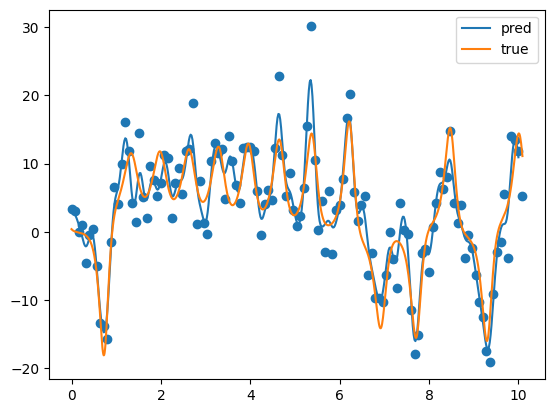

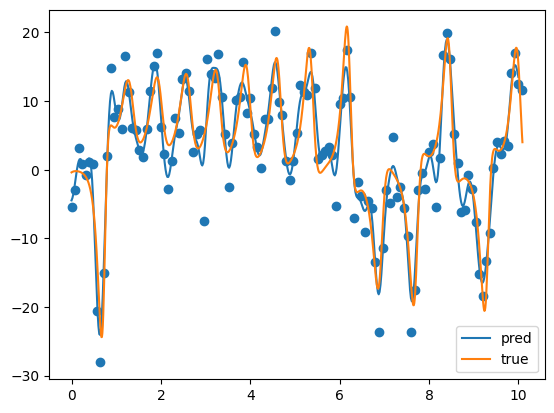

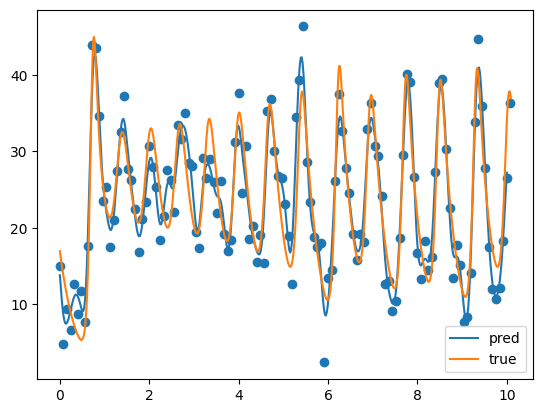

In [16]:
tgrid = jnp.linspace(0,10,500)
xpred = model.predict_state(tgrid,z0)


for index in range(3):
    plt.plot(tgrid,xpred[:,index],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,index],label = 'true')

    plt.scatter(expdata.t_train,expdata.x_train[:,index])
    plt.legend()
    plt.show()